In [84]:
# HIDE
import pandas as pd
import numpy as np
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.models import load_model


create_gif = False

# model reconstruction from JSON:
from keras.models import model_from_json

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"kerads: {ke.__version__}")

sklearn: 0.19.1
pandas: 0.23.0
kerads: 2.1.6


In [85]:
ls

Obtaining Datasets/
README.md*
Trade-off-results/
__pycache__/
acc_p_BAdata--adult.data_CP_N_T__<=50K__<=50K__>50K_S__Male__Male__Female_.txt
data/
main_task_ori_trained_model.h5
my_functions_product1.py
product1_main.py*
step_by_step-10.ipynb
step_by_step-11.ipynb
step_by_step-7.ipynb
step_by_step-8.ipynb
step_by_step-9.ipynb
y_preddata--adult.data_CP_N_T__<=50K__<=50K__>50K_S__Male__Male__Female_.txt


In [87]:
import my_functions_product1 as myFC

# reading the file from a path and list the field names and input columns of interest
#path = 'data/adult.data'
#path = 'data/compas.csv'
path = 'data/bank.csv'
X_df, Ybin, Zbin, result_fname = myFC.read_process_data_output_bias(path)

Columns in your data are:
  ['age' 'job' 'marital' 'education' 'default' 'housing' 'loan' 'contact'
 'month' 'day_of_week' 'duration' 'campaign' 'pdays' 'previous' 'poutcome'
 'emp.var.rate' 'cons.price.idx' 'cons.conf.idx' 'euribor3m' 'nr.employed'
 'y']
Your possible target columns '{'education', 'pdays', 'default', 'age', 'y', 'campaign', 'marital', 'job', 'contact', 'loan', 'month', 'poutcome', 'cons.conf.idx', 'euribor3m', 'day_of_week', 'emp.var.rate', 'previous', 'cons.price.idx', 'housing', 'duration', 'nr.employed'}'
Which column is your target column?:y
Your target column is 'y'
Do you have any column for your current prediction? Please enter Y or N:N
Do you have any column for your current prediction? You entered'N'
Your prediction column possible values '{'no', 'yes'}'
Please enter two different labels in the target field: 
Enter label 0:no
Your target label 0 is 'no'
Enter label 1:yes
Your target label 1 is 'yes'
Your possible Sensitive Attribute columns '{'education', 'pd

### Train test split

In [88]:
X = pd.get_dummies(X_df,drop_first=True) 
print(type(X),X.shape)
print(type(X_df),X_df.shape)

<class 'pandas.core.frame.DataFrame'> (41188, 53)
<class 'pandas.core.frame.DataFrame'> (41188, 20)


In [89]:
#X = pd.get_dummies(X_df,drop_first=True) 
Y = Ybin 
Z = Zbin
test_train_ratio = 0.5

#TODO: Can I do this in Keras?
# TODO : what should be left to the user

# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, Y, Z, test_size=test_train_ratio, 
                                                                     stratify=Y, random_state=7)

# standardize the data
scaler = StandardScaler().fit(X_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), columns=df.columns, index=df.index)
X_train = X_train.pipe(scale_df, scaler) 
X_test = X_test.pipe(scale_df, scaler) 

print(X_train.shape)
print(X_test.shape)

#X_train = np.array(X_train)
#X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(20594, 53)
(20594, 53)
(20594, 53)
(20594, 53)


## Performance metrics

In [90]:
def main_task_performance(X_test,y_test,y_hat):

    main_task_accuracy = accuracy_score(y_test, y_hat)
    return main_task_accuracy

In [91]:
def bias_accuracy_performance(X_test,y_test,Z_test,trained_model):

    # predict on test set
    y_pred = trained_model.predict(X_test).ravel()#, index=y_test.index
    y_hat = (y_pred>0.5)*1


    main_task_accuracy = main_task_performance(X_test,y_test,y_hat)    
    print('Accuracy: {}'.format(format(100*main_task_accuracy,'.2f')))

    p_rule_for_Y0,p_rule_for_Y1 = myFC.bias_checker_p_rule_bin(Z_test, y_hat)   

    """print('p_rule_for_Y1',p_rule_for_Y1)

    ax = sns.distplot(y_pred[Z_test == 0], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('0'))
    ax = sns.distplot(y_pred[Z_test == 1], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format('1'))"""
    return main_task_accuracy, p_rule_for_Y1,y_pred

In [92]:
"""def saving_performance_for_lambda(main_task_accuracy, p_rule_for_Y1,y_pred,tradeoff_lambda,results):
    performance_row = [main_task_accuracy, float(p_rule_for_Y1),y_pred]
    results[tradeoff_lambda]= performance_row
    return results"""

'def saving_performance_for_lambda(main_task_accuracy, p_rule_for_Y1,y_pred,tradeoff_lambda,results):\n    performance_row = [main_task_accuracy, float(p_rule_for_Y1),y_pred]\n    results[tradeoff_lambda]= performance_row\n    return results'

In [93]:
def saving_performance_result(before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred,after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred,tradeoff_lambda,result_fname):
    #BA: before after
    
    #saving accuracy and p score
    result_fname_acc_p_before_after = 'acc_p_BA_'+result_fname + 'L'+ str(tradeoff_lambda)+'.txt'
    result_fname_acc_p_before_after = './Trade-off-results/'+result_fname_acc_p_before_after
    
    Bacc_Bp_Aacc_Ap = np.array([float(before_main_task_accuracy), float(before_p_rule_for_Y1),float(after_main_task_accuracy), float(after_p_rule_for_Y1)])
    np.savetxt(result_fname_acc_p_before_after,Bacc_Bp_Aacc_Ap , delimiter=',')   


    #saving y_pred
    result_fname_y_pred_before_after = 'y_pred_'+result_fname +'L' + str(tradeoff_lambda) +'.txt'
    result_fname_y_pred_before_after = './Trade-off-results/'+ result_fname_y_pred_before_after
    before_y_pred = before_y_pred.reshape(len(before_y_pred),1)
    after_y_pred = after_y_pred.reshape(len(after_y_pred),1)
    
    BA_y_pred = np.concatenate((before_y_pred, after_y_pred), axis=1)
    np.savetxt(result_fname_y_pred_before_after, BA_y_pred, delimiter=',')  
    
    
    
    
    return result_fname_y_pred_before_after,result_fname_acc_p_before_after

In [94]:
ls

Obtaining Datasets/
README.md*
Trade-off-results/
__pycache__/
acc_p_BAdata--adult.data_CP_N_T__<=50K__<=50K__>50K_S__Male__Male__Female_.txt
data/
main_task_ori_trained_model.h5
my_functions_product1.py
product1_main.py*
step_by_step-10.ipynb
step_by_step-11.ipynb
step_by_step-7.ipynb
step_by_step-8.ipynb
step_by_step-9.ipynb
y_preddata--adult.data_CP_N_T__<=50K__<=50K__>50K_S__Male__Male__Female_.txt


### Architectures

In [95]:
def Classifier_arch(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    dense3 = Dense(32, activation="relu")(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    dense4 = Dense(32, activation="relu")(dropout3)
    dropout4 = Dropout(0.2)(dense4)
    outputs = Dense(1, activation='sigmoid')(dropout4)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [96]:
def Adversary_arch(inputs):
    dense1 = Dense(32, activation='relu')(inputs)
    dense2 = Dense(32, activation='relu')(dense1)
    dense3 = Dense(32, activation='relu')(dense2)
    dense4 = Dense(32, activation="relu")(dense3)
    outputs = Dense(1, activation='sigmoid')(dense4)# for _ in range(n_sensitive)]
    return Model(inputs=[inputs], outputs=outputs)

#### Creating and saving the classifer architecture

In [97]:
main_task_arch = Classifier_arch(n_features=X_train.shape[1])
main_task_arch_json_string = main_task_arch.to_json()

#### Creating and saving the  adversary architecture

In [98]:
adv_inputs = Input(shape=(1,))
adv_task_arch = Adversary_arch(adv_inputs)
adv_task_arch_json_string = adv_task_arch.to_json()
    

## Try reading the classifier architecture and model/compile and check prediction results

In [99]:
main_task_ori = model_from_json(main_task_arch_json_string)
# initialise NeuralNet Classifier
main_task_ori.compile(loss='binary_crossentropy', optimizer='adam')
# train on train set
main_task_ori.fit(X_train, y_train, epochs=20, verbose=0)

main_task_accuracy, p_rule_for_Y1, y_pred = bias_accuracy_performance(X_test,y_test,Z_test,main_task_ori)
main_task_ori.save_weights('main_task_ori_trained_model.h5')  # creates a HDF5 file 'my_model.h5'

del main_task_ori  # deletes the existing model


Accuracy: 90.97


## Combining the main task arch with the adversarial arch

### Fair model - training adversarial and classifier together

In [100]:

tradeoff_lambda_v = [0, 10, 20, 30, 60, 100] 
pre_load_flag = True

main_task_trained_weight_file = 'main_task_ori_trained_model.h5'

for tradeoff_lambda in tradeoff_lambda_v:
    print('tradeoff_lambda = ', tradeoff_lambda)
    # initialise FairClassifier
    clf = myFC.FairClassifier(tradeoff_lambda=tradeoff_lambda,
                     main_task_arch_json_string=main_task_arch_json_string,
                     adv_task_arch_json_string=adv_task_arch_json_string,
                     pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    
    # pre-train both adverserial and classifier networks
    clf.pretrain(X_train, y_train, Z_train, verbose=0, epochs=5,pre_load_flag=pre_load_flag,main_task_trained_weight_file=main_task_trained_weight_file)
    before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred = bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    # adverserial train on train set and validate on test set
    clf.fit(X_train, y_train, Z_train, 
            validation_data=(X_test, y_test, Z_test),
            T_iter=165, save_figs=create_gif)
    after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred = bias_accuracy_performance(X_test,y_test,Z_test,clf)
    
    
    result_fname_y_pred_before_after,result_fname_acc_p_before_after = saving_performance_result(before_main_task_accuracy, before_p_rule_for_Y1,before_y_pred, after_main_task_accuracy, after_p_rule_for_Y1,after_y_pred,tradeoff_lambda,result_fname)




tradeoff_lambda =  0
Accuracy: 90.97
Accuracy: 91.04
tradeoff_lambda =  10
Accuracy: 90.97
Accuracy: 90.30
tradeoff_lambda =  20
Accuracy: 90.97
Accuracy: 90.30
tradeoff_lambda =  30
Accuracy: 90.97
Accuracy: 90.33
tradeoff_lambda =  60
Accuracy: 90.97
Accuracy: 90.15
tradeoff_lambda =  100
Accuracy: 90.97
Accuracy: 90.07


# plotting the results; trade off curve and initial and final distributions

In [101]:
tradeoff_lambda_v = [0, 10, 20, 30, 60, 100] 

Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

Bacc_Bp_Aacc_Ap_results = np.zeros([len(tradeoff_lambda_v),4])

for item in range(len(tradeoff_lambda_v)):
    
    tradeoff_lambda = tradeoff_lambda_v[item]
    result_fname_acc_p_before_after = 'acc_p_BA_'+result_fname + 'L'+ str(tradeoff_lambda)+'.txt'
    result_fname_acc_p_before_after = './Trade-off-results/'+result_fname_acc_p_before_after
    Bacc_Bp_Aacc_Ap = np.loadtxt(result_fname_acc_p_before_after, delimiter=',')

    Bacc_Bp_Aacc_Ap_results[item, :] = Bacc_Bp_Aacc_Ap
    


Text(0.5,1,'Trade off')

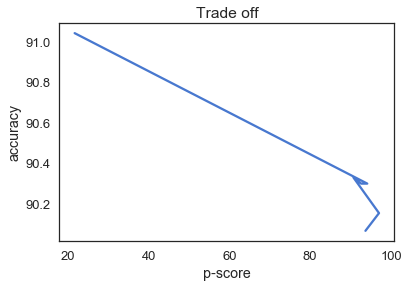

In [102]:
import matplotlib.pyplot as plt


plt.plot(Bacc_Bp_Aacc_Ap_results[:,3], 100*Bacc_Bp_Aacc_Ap_results[:,2])
plt.xlabel('p-score')
plt.ylabel('accuracy')
plt.title('Trade off')

In [103]:
result_fname_y_pred_before_after = 'y_pred_'+result_fname +'L' + str(tradeoff_lambda) +'.txt'
result_fname_y_pred_before_after = './Trade-off-results/'+ result_fname_y_pred_before_after

BA_y_pred = np.loadtxt(result_fname_y_pred_before_after, delimiter=',')

## Before the de-biaser

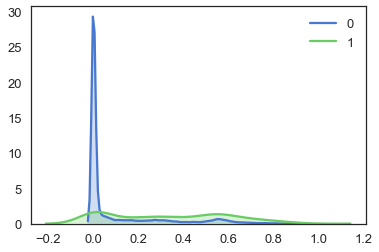

In [104]:
ax = sns.distplot(BA_y_pred[Z_test == 0,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,0], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))

## After the de-biaser

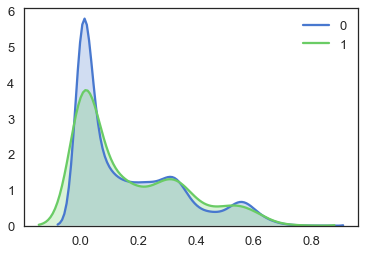

In [105]:
ax = sns.distplot(BA_y_pred[Z_test == 0,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('0'))

ax = sns.distplot(BA_y_pred[Z_test == 1,1], hist=False, 
                  kde_kws={'shade': True,},
                  label='{}'.format('1'))